# Algorithmic trading based on mean-variance optimization in Python

This is the fifth part of a series of articles on backtesting trading strategies in Python. The previous ones described the following topics:
* introducing the `zipline` framework and presenting how to test basic strategies 
* importing custom data to use with `zipline` 
* evaluating the performance of trading strategies 
* implementing trading strategies based on Technical Analysis

This time, the goal of the article is to show how to create trading strategies using Markowitz's portfolio optimization and the Modern Portfolio Theory. 

In this article, I first give a brief introduction/reminder on the mean-variance optimization and then show how to implement it into trading strategies. Just as before, I will backtest them using the `zipline` framework.

## Importing Libraries

In [1]:
%load_ext watermark

In [2]:
%load_ext zipline

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# import helper functions 
import qf_helper_functions as qf

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

Below you can see the list of libraries used in this article, together with their versions.

In [5]:
%watermark --iversions

zipline    1.3.0
numpy      1.14.6
json       2.0.9
matplotlib 3.0.0
empyrical  0.5.0
pyfolio    0.9.2
pandas     0.22.0



## Primer on mean-variance optimization

In 1952 Harry Markowitz published the “Portfolio Selection”, which described an investment theory now known as the Modern Portfolio Theory (MPT in short). Some of the key takeaways are:
* the portfolio return is the weighted average of the individual portfolio constituents, however, the volatility is also impacted by the correlation between the assets
* the investors should not evaluate the performance of the assets separately, but see how they would influence the performance of a portfolio
* diversification (spreading the allocation over multiple assets instead of one or very few) can greatly decrease the portfolio's volatility

We will not go deeply into the assumptions of MPT, but the main ones are that all investors share the goal of maximizing the returns on investment while avoiding as much risk as possible, they can borrow and lend money at the risk-free rate (without limits) and the transaction costs are not taken into account.

Based on all of the above, the mean-variance analysis is the process of finding optimal asset allocation that provides the best trade-off between the expected return and risk (measured as the variance of returns). A key concept connected to the mean-variance analysis is the Efficient Frontier - a set of optimal portfolios providing the highest expected portfolio return for a given level of risk - or framing it differently - providing the minimum level of risk for the expected portfolio return.

Mathematically, one of the possible formulations of the problem is the following:

$$ \min w^T\Sigma w$$
$$ \begin{align*}
    s.t. \quad w^T\textbf{1} = 1 \\
    w \geq 0 \\
    w^T \mu = \mu_p
    \end{align*} $$
    
where w is the vector of weights, \mu is a vector of asset returns, \Sigma is the covariance matrix, \mu_p is the target expected portfolio return. Two of the constraints are:
* non-negative weights 0 short-selling is not allowed
* weights must sum up to 1 - no leverage is allowed

To solve the problem and obtain the Efficient Frontier, we could define a range of possible expected portfolio returns and then for each  value find the weights that minimize the variance. Fortunately, there is a library that makes the process very simple. 

PyPortfolioOpt makes it possible to solve the entire optimization problem with only a few lines of code. In this article, we will create portfolios that either maximize the expected Sharpe ratio (portfolio's excess return per unit of risk) or minimize the overall volatility. Both of these portfolios lie on the Efficient Frontier.

We present how to work with `pypfopt` in the following short example. First, we download the historical stock prices using `yahoofinancials`.

In [6]:
risky_assets = ['TSLA', 'MSFT', 'FB', 'TWTR']

yahoo_financials = YahooFinancials(risky_assets)
data = yahoo_financials.get_historical_price_data('2019-01-01', '2019-09-30', 'daily')

prices_df = pd.DataFrame({
    asset: {x['formatted_date']: x['adjclose'] for x in data[asset]['prices']} for asset in risky_assets
})

prices_df.head()

,FB,MSFT,TSLA,TWTR
2019-01-02,135.679993,99.985695,310.119995,28.809999
2019-01-03,131.740005,96.307419,300.359985,27.990000
2019-01-04,137.949997,100.786606,317.690002,29.950001
2019-01-07,138.050003,100.915146,334.959991,31.340000
2019-01-08,142.529999,101.646843,335.350006,31.799999


`pypfopt` allows us to easily calculate the expected returns and the covariance matrix directly from the prices, with no need for converting to returns beforehand.

In [9]:
# calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(prices_df)
cov_mat = risk_models.sample_cov(prices_df)

We obtain the weights maximizing the Sharpe ratio by running the following lines of code:

In [13]:
# get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
cleaned_weights

{'FB': 0.03787, 'MSFT': 0.83889, 'TSLA': 0.0, 'TWTR': 0.12324}

For convenience we use the `clean_weights()` method, as it truncates very small weights to zero and rounds the rest.

## Strategies

In this article we use the following problem setting:
* the investor has a capital of 50000$
* the investment horizon covers years 2016-2017
* the investor can only invest in the following stocks: Tesla, Microsoft, Facebook, Twitter
* we assume no transactions costs
* there is no short selling (the investor can only sell what he/she currently owns)
* when performing optimization, the investor considers 252 past trading days to calculate the historical returns and covariance matrix
* the first trading decision is made on the last day of December, but the orders are executed on the first trading day of January 2016

### Benchmark 1/n strategy

We start by creating a simple benchmark strategy - the **1/n portfolio**. The idea is very simple - on the first day of the test, we allocate 1/n% of our total capital to each of the considered n assets. To keep it simple, we do not do any rebalancing.
What often happens in practice is that the portfolio is rebalanced every X days to bring the allocation back to 1/n. Why? We can imagine that we hold a portfolio of two assets X and Y and at the beginning of the investment horizon the allocation is 50–50. Over a month, the price of X increased sharply while the price of Y decreased. As a result, asset X constitutes 65% of our portfolio's worth, while Y has only 35%. We might want to rebalance back to 50–50 by selling some of X and buying more Y.

In [9]:
%%zipline --start 2015-12-31 --end 2017-12-31 --capital-base 50000.0 -o benchmark.pkl

# imports
from zipline.api import order_percent, symbols
from zipline.finance import commission
import numpy as np 
import pandas as pd

def initialize(context):
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.assets = symbols('TSLA', 'MSFT', 'FB', 'TWTR')
    context.n_assets = len(context.assets)
    context.has_position = False

def handle_data(context, data):
    if not context.has_position:
        for asset in context.assets:
            order_percent(asset, 1/context.n_assets)
        context.has_position = True

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-12-31 21:00:00+00:00,NaN,0.000000,NaN,-0.010003,NaN,NaN,0.00000,50000.00000,0.000,0.000,...,0.0,0.0,0,NaN,50000.00000,0.000,0.000,1,[],0.0
2016-01-04 21:00:00+00:00,0.005421,-0.000483,0.306185,-0.023843,0.044632,0.121461,-48318.04695,1681.95305,48293.900,48293.900,...,0.0,0.0,0,-11.224972,50000.00000,0.000,0.000,2,"[{'amount': 540, 'price': 22.571279999999998, ...",0.0
2016-01-05 21:00:00+00:00,0.039716,-0.005035,-0.964702,-0.022192,0.129315,-0.289213,0.00000,1681.95305,48066.280,48066.280,...,0.0,0.0,0,-10.080453,1681.95305,48293.900,48293.900,3,[],0.0
2016-01-06 21:00:00+00:00,0.105220,-0.019254,-1.064516,-0.034526,0.113319,0.069639,0.00000,1681.95305,47355.360,47355.360,...,0.0,0.0,0,-10.223002,1681.95305,48066.280,48066.280,4,[],0.0
2016-01-07 21:00:00+00:00,0.245348,-0.055462,0.686586,-0.057690,0.146203,1.186304,0.00000,1681.95305,45544.930,45544.930,...,0.0,0.0,0,-10.019812,1681.95305,47355.360,47355.360,5,[],0.0
2016-01-08 21:00:00+00:00,0.219910,-0.064007,0.746360,-0.068033,0.130871,1.188767,0.00000,1681.95305,45117.720,45117.720,...,0.0,0.0,0,-10.354429,1681.95305,45544.930,45544.930,6,[],0.0
2016-01-11 21:00:00+00:00,0.202100,-0.070553,-0.281693,-0.067110,0.141494,0.935818,0.00000,1681.95305,44790.390,44790.390,...,0.0,0.0,0,-10.461128,1681.95305,45117.720,45117.720,7,[],0.0
2016-01-12 21:00:00+00:00,0.216588,-0.062086,-0.091200,-0.059583,0.165116,0.991225,0.00000,1681.95305,45213.770,45213.770,...,0.0,0.0,0,-8.552228,1681.95305,44790.390,44790.390,8,[],0.0
2016-01-13 21:00:00+00:00,0.254412,-0.096767,0.005388,-0.083038,0.179647,1.170145,0.00000,1681.95305,43479.680,43479.680,...,0.0,0.0,0,-9.539587,1681.95305,45213.770,45213.770,9,[],0.0
2016-01-14 21:00:00+00:00,0.302625,-0.073618,0.326722,-0.067984,0.213660,1.261775,0.00000,1681.95305,44637.140,44637.140,...,0.0,0.0,0,-6.734169,1681.95305,43479.680,43479.680,10,[],0.0


We inspect performance of the benchmark strategy by creating a tear sheet. First we load the performance DataFrame from the pickle file. 

In [10]:
benchmark_df = pd.read_pickle('benchmark.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(benchmark_df)

The following code generates the tear sheet.

In [11]:
#pf.create_returns_tear_sheet(returns, positions, transactions)

We also store some results to compare with the other strategies.

In [12]:
benchmark_perf = qf.get_performance_summary(returns)

### Maximum Sharpe ratio portfolio - rebalancing every 30 days

In this strategy, the investor selects such weights that maximize the portfolio's expected Sharpe ratio. The portfolio is rebalanced every 30 trading days. 

We determine if a given day is a rebalancing day by using the modulo operation (`%` in Python) on the current trading day's number (stored in `context.time`). We rebalance on days when the reminder after the division by 30 is 0.

In [13]:
%%zipline --start 2015-12-31 --end 2017-12-31 --capital-base 50000.0 -o max_sharpe_30_days.pkl

# imports
from zipline.api import symbols, record, order_target_percent
from zipline.finance import commission
import numpy as np 
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def initialize(context):
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.assets = symbols('TSLA', 'MSFT', 'FB', 'TWTR')
    context.n_assets = len(context.assets)
    context.window = 252
    context.rebalance_period = 30
    context.time = 0


def handle_data(context, data):
    cleaned_weights = []
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        # extract prices
        prices = data.history(context.assets, fields='price',
                              bar_count=context.window + 1, frequency='1d')
        
        # calculate expected returns and sample covariance amtrix
        avg_returns = expected_returns.mean_historical_return(prices)
        cov_mat = risk_models.sample_cov(prices)

        # get weights maximizing the Sharpe ratio
        ef = EfficientFrontier(avg_returns, cov_mat)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()

        # submit orders
        for asset in context.assets:
            order_target_percent(asset, cleaned_weights[asset])
    
    record(weights=cleaned_weights)
    context.time += 1

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,weights
2015-12-31 21:00:00+00:00,NaN,0.000000,NaN,-0.010003,NaN,NaN,0.00000,50000.000000,0.000,0.000,...,0.0,0,NaN,50000.000000,0.000,0.000,1,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-04 21:00:00+00:00,0.005485,-0.000489,0.309803,-0.023843,0.044632,0.122896,-48889.05231,1110.947690,48864.620,48864.620,...,0.0,0,-11.224972,50000.000000,0.000,0.000,2,"[{'amount': 381, 'price': 102.27111, 'dt': 201...",0.0,[]
2016-01-05 21:00:00+00:00,0.046335,0.004303,1.023684,-0.022192,0.129315,0.353579,0.00000,1110.947690,49104.180,49104.180,...,0.0,0,80.743542,1110.947690,48864.620,48864.620,3,[],0.0,[]
2016-01-06 21:00:00+00:00,0.045650,0.002511,1.013883,-0.034526,0.113319,0.388819,0.00000,1110.947690,49014.620,49014.620,...,0.0,0,10.822067,1110.947690,49104.180,49104.180,4,[],0.0,[]
2016-01-07 21:00:00+00:00,0.327567,-0.042775,3.264149,-0.057690,0.146203,1.823796,0.00000,1110.947690,46750.290,46750.290,...,0.0,0,-6.697434,1110.947690,49014.620,49014.620,5,[],0.0,[]
2016-01-08 21:00:00+00:00,0.294394,-0.046692,3.406261,-0.068033,0.130871,1.829652,0.00000,1110.947690,46554.460,46554.460,...,0.0,0,-6.673132,1110.947690,46750.290,46750.290,6,[],0.0,[]
2016-01-11 21:00:00+00:00,0.274252,-0.045429,2.113136,-0.067110,0.141494,1.511483,0.00000,1110.947690,46617.610,46617.610,...,0.0,0,-6.003012,1110.947690,46554.460,46554.460,7,[],0.0,[]
2016-01-12 21:00:00+00:00,0.285237,-0.029518,1.834801,-0.059583,0.165116,1.430525,0.00000,1110.947690,47413.150,47413.150,...,0.0,0,-3.554561,1110.947690,46617.610,46617.610,8,[],0.0,[]
2016-01-13 21:00:00+00:00,0.314645,-0.063591,1.889312,-0.083038,0.179647,1.531502,0.00000,1110.947690,45709.480,45709.480,...,0.0,0,-5.888207,1110.947690,47413.150,47413.150,9,[],0.0,[]
2016-01-14 21:00:00+00:00,0.348995,-0.035943,1.732899,-0.067984,0.213660,1.486900,0.00000,1110.947690,47091.880,47091.880,...,0.0,0,-3.003357,1110.947690,45709.480,45709.480,10,[],0.0,[]


In [14]:
max_sharpe_30_days_df = pd.read_pickle('max_sharpe_30_days.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(max_sharpe_30_days_df)

Below we extracted the asset allocation:

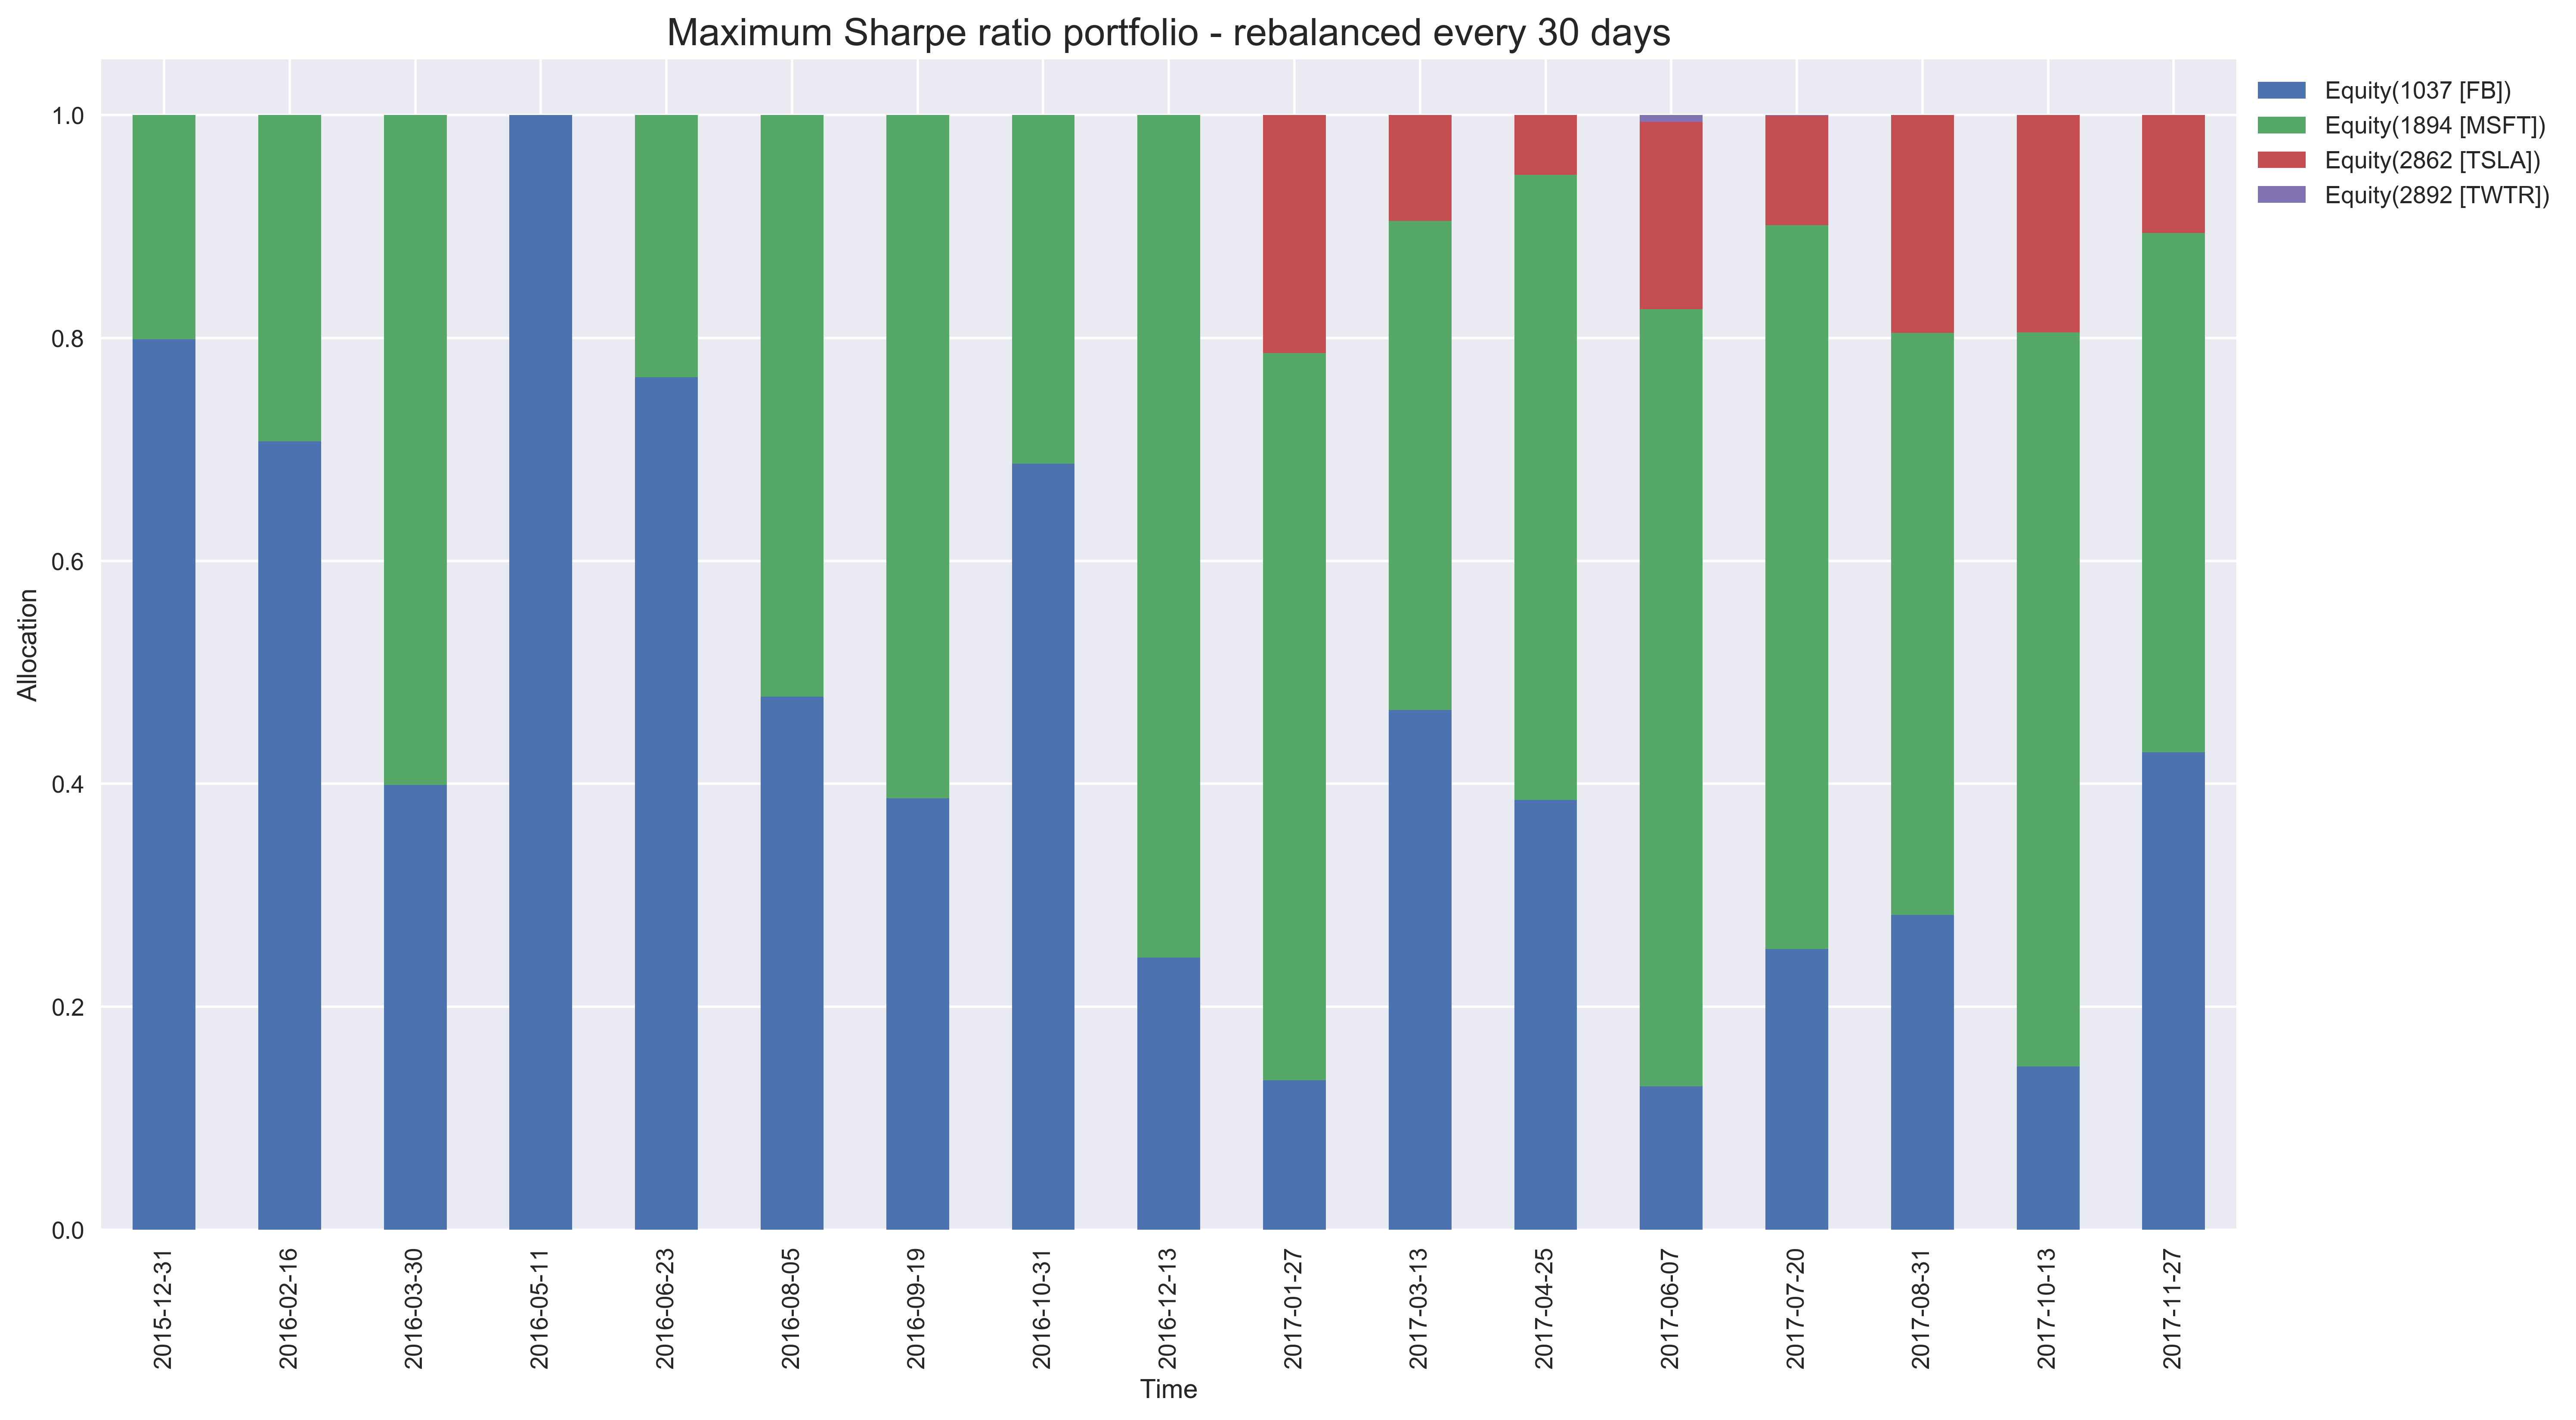

In [15]:
# extract non-empty weights
filtered_weights = max_sharpe_30_days_df.loc[max_sharpe_30_days_df['weights'].map(lambda d: len(d)) > 0, 'weights']

# convert index to datatime
new_index = pd.Series(pd.to_datetime(filtered_weights.index).date).map(lambda x: x.strftime('%Y-%m-%d'))
weights_df = pd.DataFrame.from_records(filtered_weights, index=new_index)

# plot the results
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(xlabel='Time', ylabel='Allocation')
ax.set_title('Maximum Sharpe ratio portfolio - rebalanced every 30 days', fontsize=16)
ax.legend(bbox_to_anchor=(1,1));

Some of the insights from the plot:
* there is virtually no investment in Twitter in this strategy
* sometimes entire months are skipped like Jan 2016 or April 2016. That is because we are rebalancing every 30 trading days and there are on average 21 trading days in a month.

In [16]:
# inspect the transactions 
# transactions

In [17]:
# create the tear sheet
# pf.create_returns_tear_sheet(returns, positions, transactions)

As before, we also store some results for later comparison.

In [18]:
max_sharpe_30_days_perf = qf.get_performance_summary(returns)

### Maximum Sharpe ratio portfolio - rebalancing every month

This strategy is very similar to the previous one - we also select weights maximizing the portfolio's expected Sharpe ratio. The difference is in the rebalancing scheme. First, we define the `rebalance` method which calculates the optimal weights and executes orders accordingly. Then, we schedule it using `schedule_function`. With the current setting, the rebalancing happens on the last trading day of the month (`date_rules.month_end`) after the market closes (`time_rules.market_close`).

In [19]:
%%zipline --start 2015-12-31 --end 2017-12-31 --capital-base 50000.0 -o max_sharpe_monthly.pkl

# imports
from zipline.api import (symbols, record, order_target_percent, 
                         schedule_function, date_rules, time_rules)
from zipline.finance import commission
import numpy as np 
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def initialize(context):
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.assets = symbols('TSLA', 'MSFT', 'FB', 'TWTR')
    context.n_assets = len(context.assets)
    context.window = 252
    
    schedule_function(rebalance,
                      date_rules.month_end(),
                      time_rules.market_close())

def rebalance(context, data):
    cleaned_weights = []
        
    # extract prices
    prices = data.history(context.assets, fields='price',
                          bar_count=context.window + 1, frequency='1d')

    # calculate expected returns and sample covariance amtrix
    avg_returns = expected_returns.mean_historical_return(prices)
    cov_mat = risk_models.sample_cov(prices)

    # get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    
    # submit orders
    for asset in context.assets:
        order_target_percent(asset, cleaned_weights[asset])
    
    record(weights=cleaned_weights)

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,weights
2015-12-31 21:00:00+00:00,NaN,0.000000,NaN,-0.010003,NaN,NaN,0.000000,50000.000000,0.000,0.000,...,0.0,0,NaN,50000.000000,0.000,0.000,1,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-04 21:00:00+00:00,0.005485,-0.000489,0.309803,-0.023843,0.044632,0.122896,-48889.052310,1110.947690,48864.620,48864.620,...,0.0,0,-11.224972,50000.000000,0.000,0.000,2,"[{'amount': 381, 'price': 102.27111, 'dt': 201...",0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-05 21:00:00+00:00,0.046335,0.004303,1.023684,-0.022192,0.129315,0.353579,0.000000,1110.947690,49104.180,49104.180,...,0.0,0,80.743542,1110.947690,48864.620,48864.620,3,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-06 21:00:00+00:00,0.045650,0.002511,1.013883,-0.034526,0.113319,0.388819,0.000000,1110.947690,49014.620,49014.620,...,0.0,0,10.822067,1110.947690,49104.180,49104.180,4,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-07 21:00:00+00:00,0.327567,-0.042775,3.264149,-0.057690,0.146203,1.823796,0.000000,1110.947690,46750.290,46750.290,...,0.0,0,-6.697434,1110.947690,49014.620,49014.620,5,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-08 21:00:00+00:00,0.294394,-0.046692,3.406261,-0.068033,0.130871,1.829652,0.000000,1110.947690,46554.460,46554.460,...,0.0,0,-6.673132,1110.947690,46750.290,46750.290,6,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-11 21:00:00+00:00,0.274252,-0.045429,2.113136,-0.067110,0.141494,1.511483,0.000000,1110.947690,46617.610,46617.610,...,0.0,0,-6.003012,1110.947690,46554.460,46554.460,7,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-12 21:00:00+00:00,0.285237,-0.029518,1.834801,-0.059583,0.165116,1.430525,0.000000,1110.947690,47413.150,47413.150,...,0.0,0,-3.554561,1110.947690,46617.610,46617.610,8,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-13 21:00:00+00:00,0.314645,-0.063591,1.889312,-0.083038,0.179647,1.531502,0.000000,1110.947690,45709.480,45709.480,...,0.0,0,-5.888207,1110.947690,47413.150,47413.150,9,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."
2016-01-14 21:00:00+00:00,0.348995,-0.035943,1.732899,-0.067984,0.213660,1.486900,0.000000,1110.947690,47091.880,47091.880,...,0.0,0,-3.003357,1110.947690,45709.480,45709.480,10,[],0.0,"{Equity(2892 [TWTR]): 0.0, Equity(1894 [MSFT])..."


In [20]:
max_sharpe_monthly_df = pd.read_pickle('max_sharpe_monthly.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(max_sharpe_monthly_df)

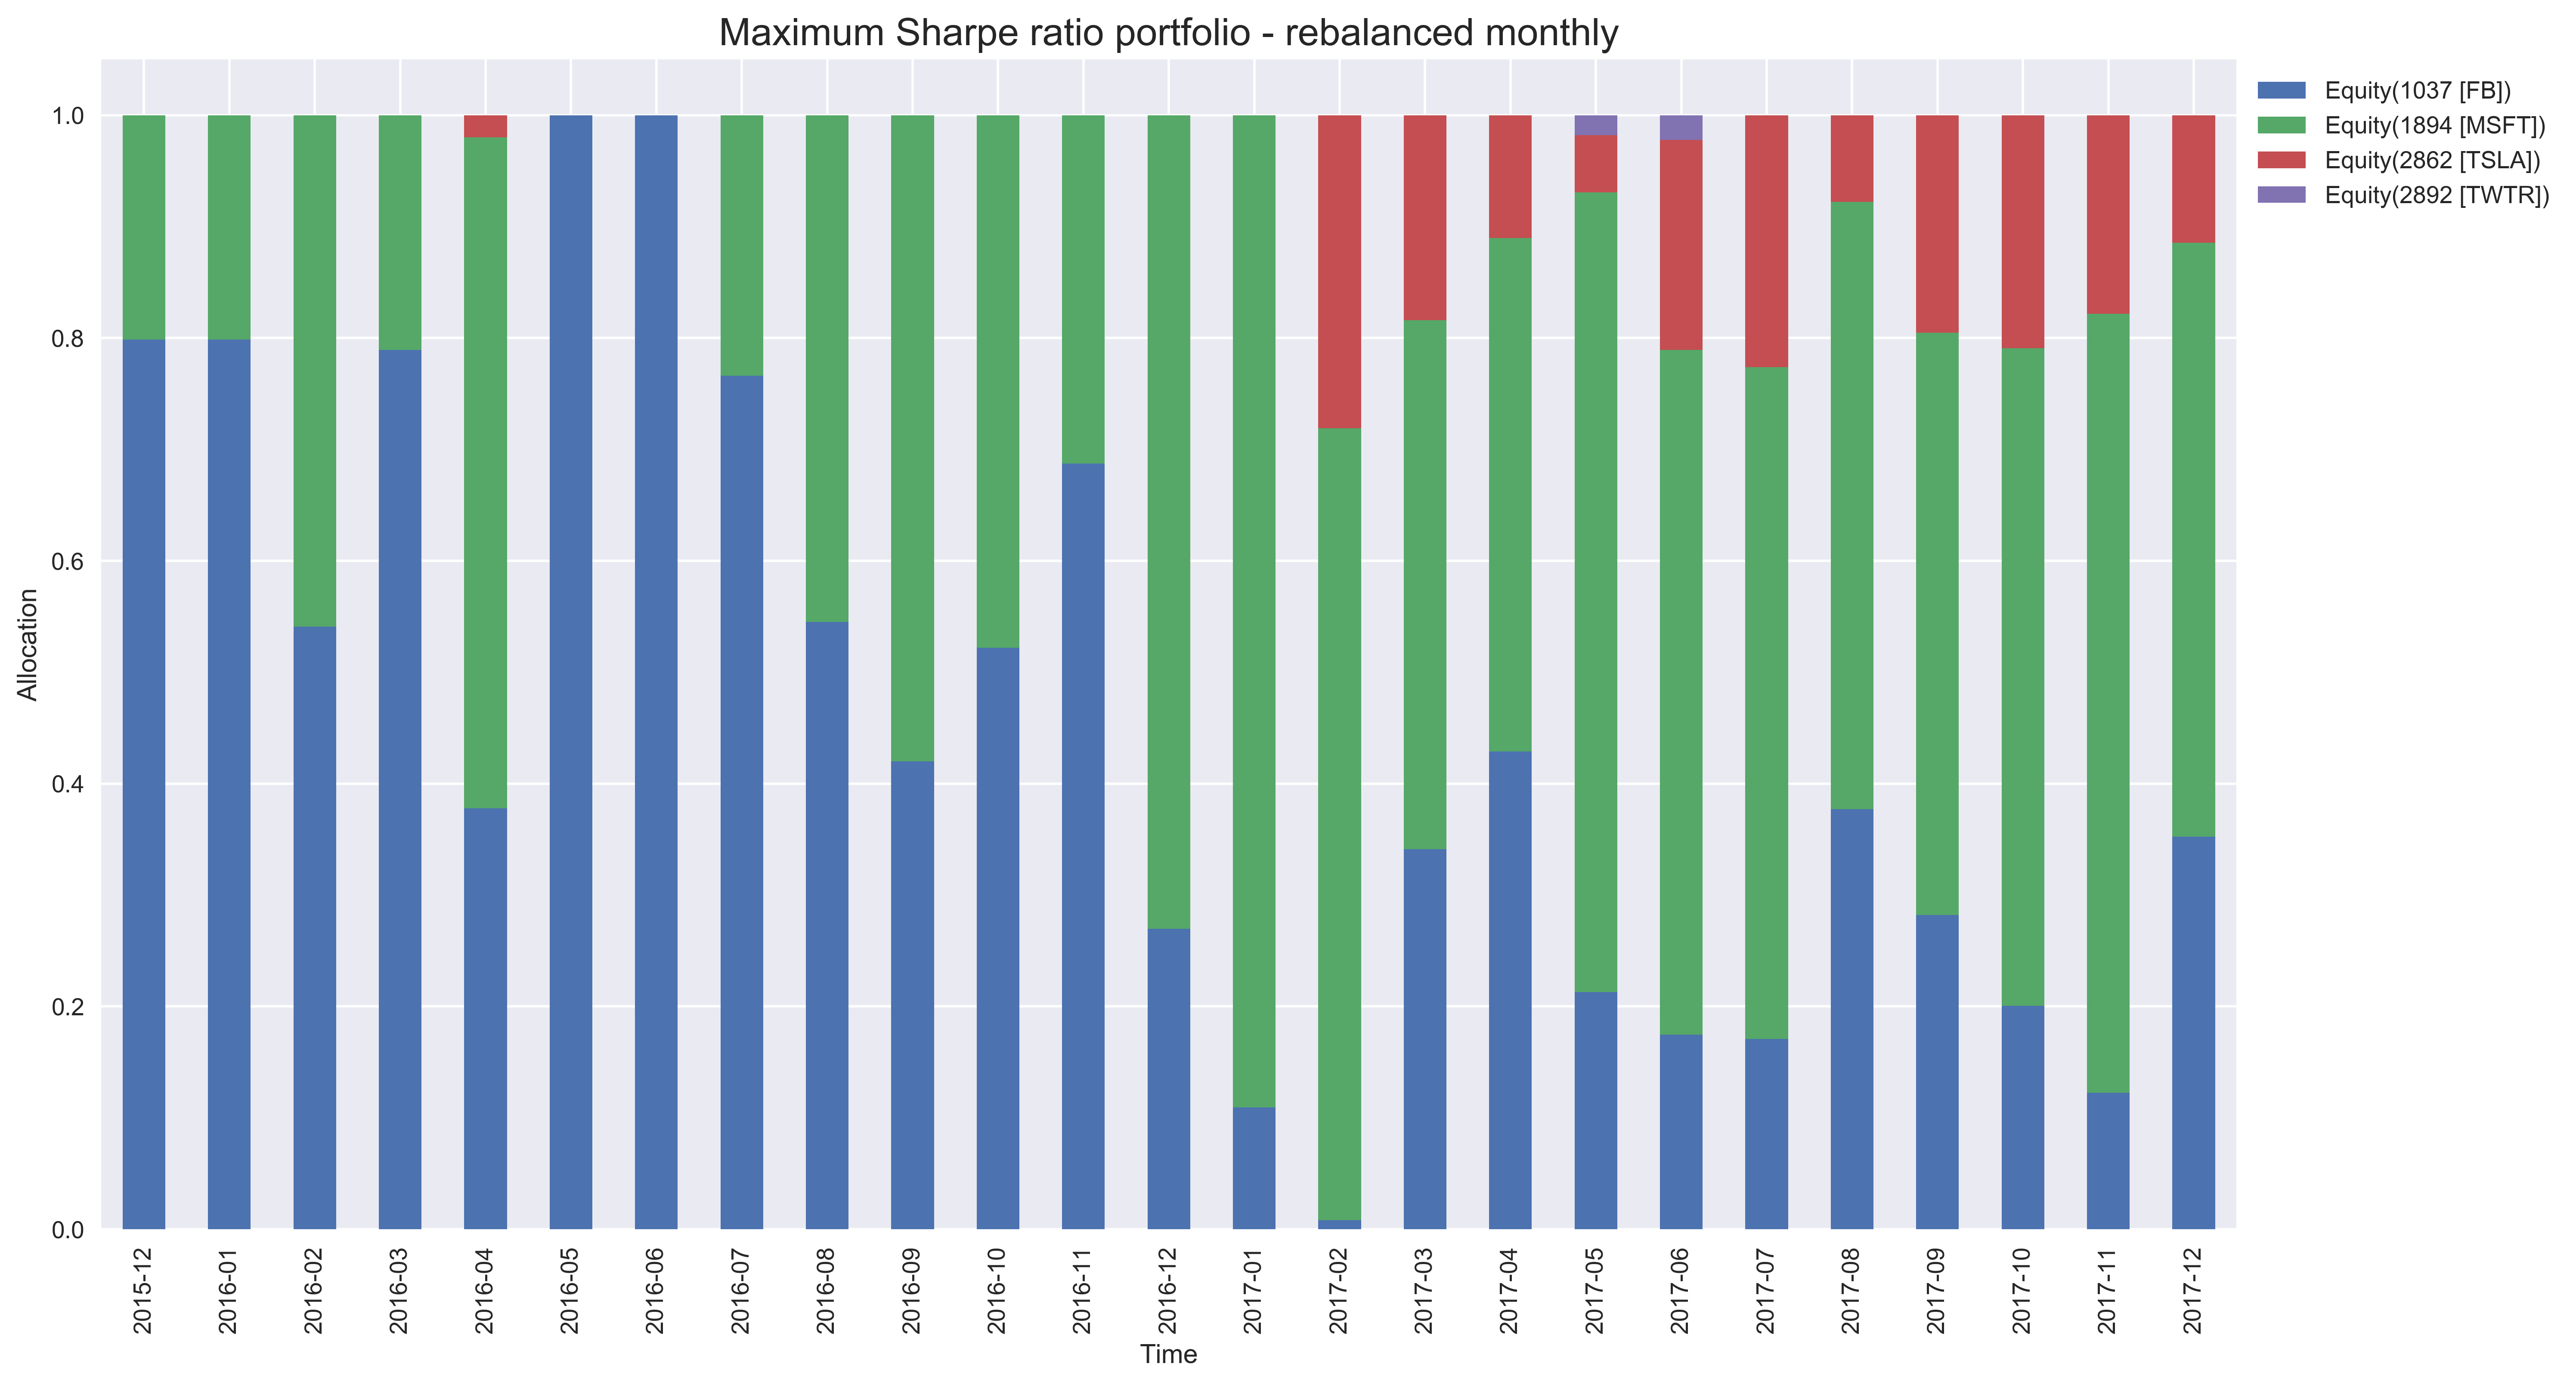

In [21]:
# extract non-empty weights
filtered_weights = max_sharpe_monthly_df.loc[max_sharpe_monthly_df['weights'].map(lambda d: len(d)) > 0, 'weights']

# convert index to datatime
new_index = pd.Series(pd.to_datetime(max_sharpe_monthly_df.weights.index).date).map(lambda x: x.strftime('%Y-%m'))
weights_df = pd.DataFrame.from_records(filtered_weights, index=new_index)

# select only the first value per month to remove duplicates
weights_df = weights_df.groupby(weights_df.index).head(1)

# plot the results
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(xlabel='Time', ylabel='Allocation')
ax.set_title('Maximum Sharpe ratio portfolio - rebalanced monthly', fontsize=16)
ax.legend(bbox_to_anchor=(1,1));

When rebalancing monthly, we do have entries for all the months. Also, in this case, there are some small investments in Twitter in mid 2017.

In [22]:
max_sharpe_monthly_perf = qf.get_performance_summary(returns)

### Minimum volatility portfolio - rebalancing every month

This time the investors selects the portfolio weights by minimizing the volatility. Thanks to `PyPortfolioOpt`, this is as easy as changing `weights = ef.max_sharpe()` to `weights = ef.min_volatility()`.

In [23]:
%%zipline --start 2015-12-31 --end 2017-12-31 --capital-base 50000.0 -o min_vol_month_start.pkl

# imports
from zipline.api import (symbols, record, order_target_percent, 
                         schedule_function, date_rules, time_rules)
from zipline.finance import commission
import numpy as np 
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def initialize(context):
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.assets = symbols('TSLA', 'MSFT', 'FB', 'TWTR')
    context.n_assets = len(context.assets)
    context.window = 252
    
    schedule_function(rebalance,
                      date_rules.month_end(),
                      time_rules.market_close())

def rebalance(context, data):
    cleaned_weights = []
        
    # extract prices
    prices = data.history(context.assets, fields='price',
                          bar_count=context.window + 1, frequency='1d')

    # calculate expected returns and sample covariance amtrix
    avg_returns = expected_returns.mean_historical_return(prices)
    cov_mat = risk_models.sample_cov(prices)

    # get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.min_volatility()
    cleaned_weights = ef.clean_weights()
    
    # submit orders
    for asset in context.assets:
        order_target_percent(asset, cleaned_weights[asset])
    
    record(weights=cleaned_weights)

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,weights
2015-12-31 21:00:00+00:00,NaN,0.000000,NaN,-0.010003,NaN,NaN,0.00000,50000.00000,0.000,0.000,...,0.0,0,NaN,50000.00000,0.000,0.000,1,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-04 21:00:00+00:00,0.005463,-0.000487,0.308575,-0.023843,0.044632,0.122409,-48695.33550,1304.66450,48671.000,48671.000,...,0.0,0,-11.224972,50000.00000,0.000,0.000,2,"[{'amount': 206, 'price': 22.571279999999998, ...",0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-05 21:00:00+00:00,0.013918,0.000728,0.262642,-0.022192,0.129315,0.107566,0.00000,1304.66450,48731.750,48731.750,...,0.0,0,13.725443,1304.66450,48671.000,48671.000,3,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-06 21:00:00+00:00,0.073980,-0.008245,0.201436,-0.034526,0.113319,0.327613,0.00000,1304.66450,48283.070,48283.070,...,0.0,0,-7.281362,1304.66450,48731.750,48731.750,4,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-07 21:00:00+00:00,0.280594,-0.048451,2.091086,-0.057690,0.146203,1.532628,0.00000,1304.66450,46272.800,46272.800,...,0.0,0,-8.339798,1304.66450,48283.070,48283.070,5,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-08 21:00:00+00:00,0.253117,-0.052905,2.274746,-0.068033,0.130871,1.540197,0.00000,1304.66450,46050.090,46050.090,...,0.0,0,-8.291240,1304.66450,46272.800,46272.800,6,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-11 21:00:00+00:00,0.234770,-0.054784,1.117151,-0.067110,0.141494,1.255374,0.00000,1304.66450,45956.130,45956.130,...,0.0,0,-7.952145,1304.66450,46050.090,46050.090,7,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-12 21:00:00+00:00,0.246093,-0.042835,0.980587,-0.059583,0.165116,1.215652,0.00000,1304.66450,46553.610,46553.610,...,0.0,0,-5.742402,1304.66450,45956.130,45956.130,8,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-13 21:00:00+00:00,0.274105,-0.074872,1.037784,-0.083038,0.179647,1.321603,0.00000,1304.66450,44951.740,44951.740,...,0.0,0,-7.533247,1304.66450,46553.610,46553.610,9,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."
2016-01-14 21:00:00+00:00,0.316180,-0.049141,1.138168,-0.067984,0.213660,1.350229,0.00000,1304.66450,46238.290,46238.290,...,0.0,0,-4.540551,1304.66450,44951.740,44951.740,10,[],0.0,"{Equity(2892 [TWTR]): 0.09557, Equity(1894 [MS..."


In [24]:
min_vol_month_start_df = pd.read_pickle('min_vol_month_start.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(min_vol_month_start_df)

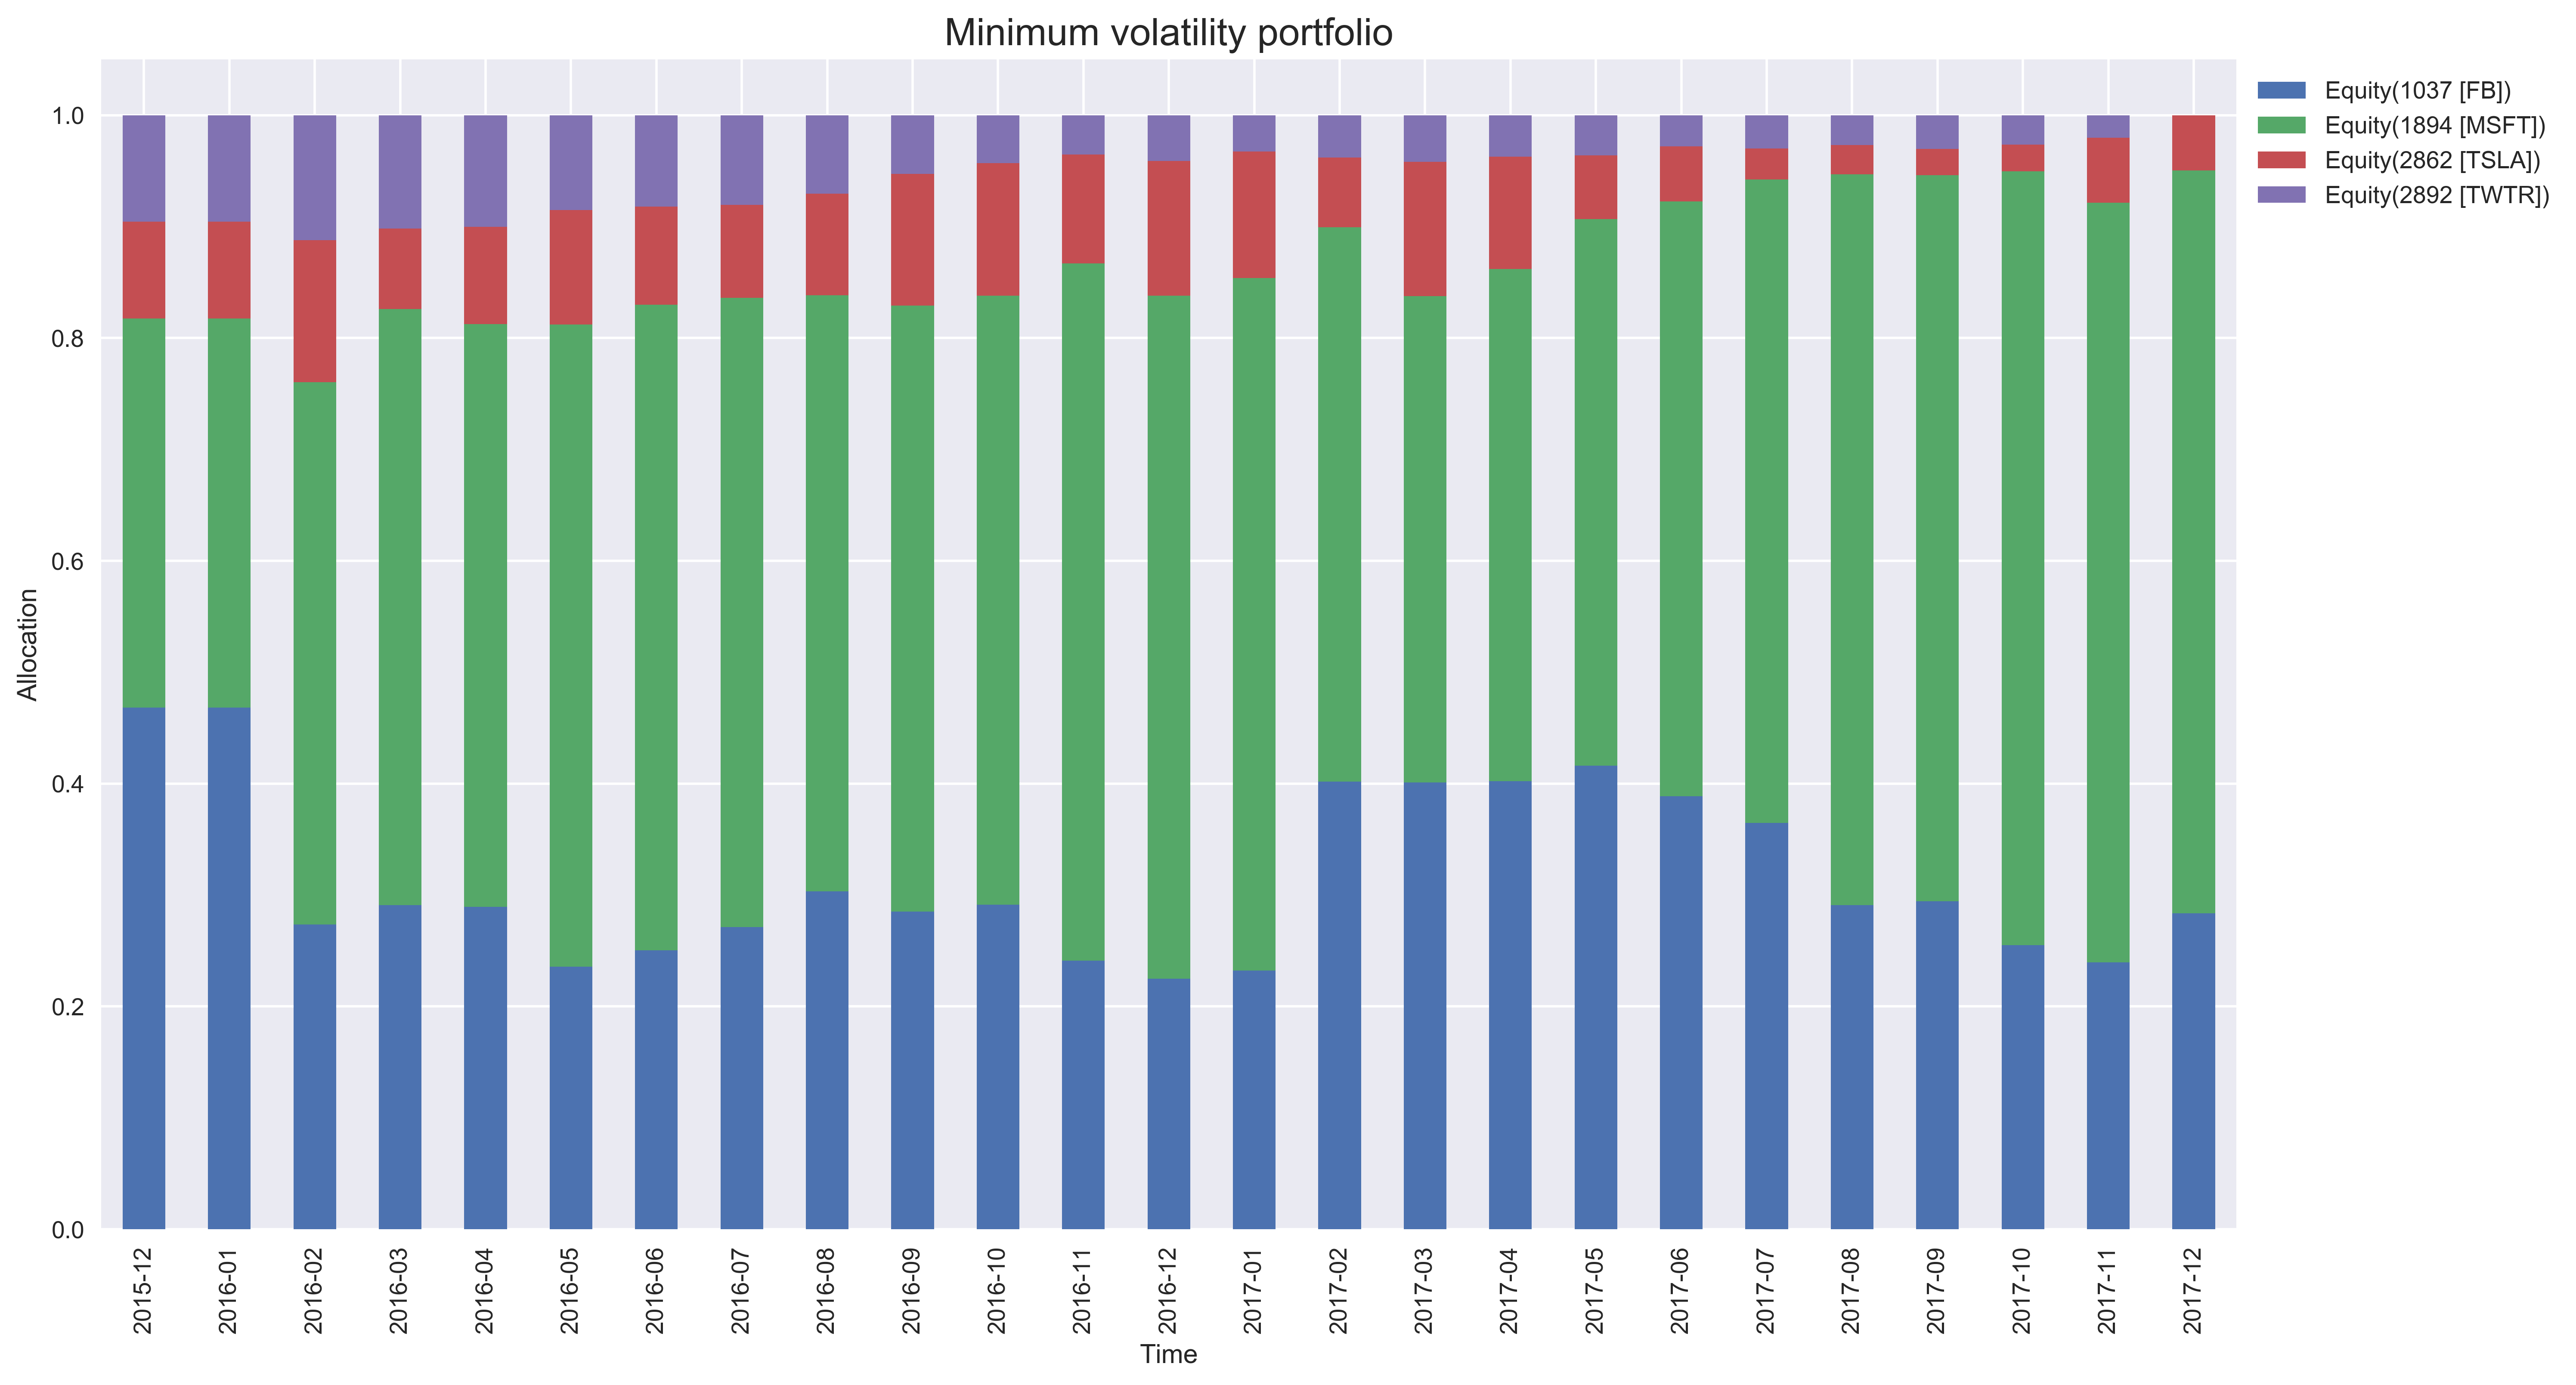

In [25]:
# extract non-empty weights
filtered_weights = min_vol_month_start_df.loc[min_vol_month_start_df['weights'].map(lambda d: len(d)) > 0, 'weights']

# convert index to datatime
new_index = pd.Series(pd.to_datetime(min_vol_month_start_df.weights.index).date).map(lambda x: x.strftime('%Y-%m'))
weights_df = pd.DataFrame.from_records(filtered_weights, index=new_index)

# select only the first value per month to remove duplicates
weights_df = weights_df.groupby(weights_df.index).head(1)

# plot the results
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(xlabel='Time', ylabel='Allocation')
ax.set_title('Minimum volatility portfolio', fontsize=16)
ax.legend(bbox_to_anchor=(1,1));

The weights generated by the minimum volatility strategy are definitely most stable over time - there is not so much rebalancing from between to consecutive periods. That is certainly important when we account for transaction costs.

In [26]:
min_vol_month_perf = qf.get_performance_summary(returns)

## Comparing the performance

From the comparison below we see that the strategy minimalizing volatility achieved the best returns together with the lowest portfolio volatility. It also performed much better than the strategies maximizing the Sharpe ratio. 

Another interesting observation is that all of the custom strategies created using optimization resulted in performance better than naive 1/n allocation combined with buy and hold.

In [27]:
perf_df = pd.DataFrame({'1/n portfolio': benchmark_perf,
                        'Max Sharpe - 30 days rebalancing': max_sharpe_30_days_perf,
                        'Max Sharpe - monthly rebalancing': max_sharpe_monthly_perf,
                        'Min Volatility - monthly rebalancing': min_vol_month_perf})
perf_df.transpose()

,annual_volatility,annualized_returns,cumulative_returns,max_drawdown,sharpe_ratio,sortino_ratio
1/n portfolio,0.202332,0.192332,0.421656,-0.197996,0.971176,1.334315
Max Sharpe - 30 days rebalancing,0.198240,0.217883,0.483238,-0.125903,1.092552,1.685077
Max Sharpe - monthly rebalancing,0.197705,0.224845,0.500245,-0.122510,1.123783,1.744523
Min Volatility - monthly rebalancing,0.183540,0.294290,0.675187,-0.138981,1.497601,2.240891


## Conclusions

In this article, I showed how to combine `zipline` with `pypfopt` in order to backtest trading strategies based on mean-variance optimization. We only covered portfolios either maximizing the Sharpe ratio or minimizing the overall volatility, however, there are definitely more possibilities.

Some of the possible future directions:
* in the optimization scheme, account for maximum potential changes in the allocation. With the zero commission setup, this is not a problem, however, in the presence of transaction costs we would like to avoiding spending too much on the fees if we completely rebalance every X days.
* allow for short-selling
* use custom objective functions in the optimization problem - optimizing using different evaluation metrics

It is crucial to remember that the fact that the strategy performed well in the past is no guarantee that this will happen again in the future.